NOTE: Do not merge all code in this branch with main. The R to Python code file in the feature/2025-26 budget projections branch should not replace the one in the main branch!

In [1]:
import os
os.getcwd()
assert os.environ.get('CONDA_DEFAULT_ENV') == 'sagemaker_renforecast_env', 'Error! Wrong environment will cause downstream versioning issues.'

In [165]:
import sys
import subprocess
import pkg_resources
import pandas as pd
import numpy as np
import sklearn
import sqlalchemy as sa
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import calendar
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
import joblib
from joblib import dump, load

# one-hot encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

# model(s)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost.callback import EarlyStopping

# train test split
from sklearn.model_selection import train_test_split

# class imbalance
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight

# eval metrics
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from math import sqrt
import shap

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\ybai\AppData\Local\anaconda3\envs\sagemaker_renforecast_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Install specific sklearn version (for Sagemaker)
subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn==1.2.1"])

# Verify installation
print(f"Scikit-learn version: {sklearn.__version__}")

Scikit-learn version: 1.2.1


## Get data

### SQL Connection

In [4]:
# set connection parameters
driver = "ODBC Driver 17 for SQL Server"
server = "SQLWRH22"
database = "NimbleReplica"
username = "ybai"

### SQLALCHEMY METHOD ###
# define connection
connection_string = "DRIVER={%s}; \
                     SERVER=%s; \
                     DATABASE=%s;\
                     UID=%s; \
                     Trusted_Connection=yes" % (driver, server, database, username)
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)

### SQL Code

In [5]:
query = """
SET NOCOUNT ON
--THIS IS THE QUERY FOR MBR RENEWAL FORECAST, ADAPTED FROM THE MMQ
;with cteNextTerm(NU__Account2__c,ControlGroupID__c, ControlGroupDate__c, CreatedDate, NU__ExternalID__c, Next_Term, 
                  Next_SubRef, Next_startdate, Next_enddate, Id, NU__OrderItemLine__c, NU__MembershipType2__c, NU__Status__c,KeyCode__c, NU__AutoRenew__c, CTC__c)
AS
(
  select NU__Account2__c, ControlGroupID__c, ControlGroupDate__c, CreatedDate, NU__ExternalID__c, Right(NU__ExternalID__c,(Len(NU__ExternalID__c) - 13)) as 'Next_Term', 
        Left(NU__ExternalID__c, 12) as 'Next_SubRef', NU__StartDate__c 'Next_startdate', NU__EndDate__c 'Next_enddate', Id, NU__OrderItemLine__c, 
        NU__MembershipType2__c, NU__Status__c, KeyCode__c, NU__AutoRenew__c, CTC__c
    from NU__Membership__c with(NOLOCK)
    where
        ISNUMERIC(Left(NU__ExternalID__c, 12)) = 1
        AND ISNUMERIC(Right(NU__ExternalID__c, Len(NU__ExternalID__c) - 13)) = 1
),
     
	 ctePrvTerm(NU__Account2__c,ControlGroupID__c, ControlGroupDate__c, CreatedDate, NU__ExternalID__c, Prv_Term, 
        Prv_SubRef, Prv_startdate, Prv_enddate, Id,NU__Status__c,KeyCode__c, NU__AutoRenew__c, CTC__c)   
   AS
   (
    select NU__Account2__c, ControlGroupID__c, ControlGroupDate__c, CreatedDate, NU__ExternalID__c, Right(NU__ExternalID__c,(Len(NU__ExternalID__c) - 13)) as 'Prv_Term', 
        Left(NU__ExternalID__c, 12) as 'Prv_SubRef' , NU__StartDate__c 'Prv_startdate', NU__EndDate__c 'Prv_enddate', Id,NU__Status__c,KeyCode__c, NU__AutoRenew__c, CTC__c
    from NU__Membership__c with(NOLOCK)
    where
        ISNUMERIC(Left(NU__ExternalID__c, 12)) = 1
        AND ISNUMERIC(Right(NU__ExternalID__c, Len(NU__ExternalID__c) - 13)) = 1
)

select 
case when Acc.CustomerNumber__c is null then ltrim(rtrim(right(left(Acc.NU__ExternalID__c,12),8))) else Acc.CustomerNumber__c end as CustomerNumber__c,
mem.NU__AutoRenew__c,
Acc.PersonEmail 'Email',
Memtyp.Name 'Member_Type', 
mem.KeyCode__c,
Case
		when Mem.ControlGroupID__c <> '' and Mem.ControlGroupDate__c < mem.CreatedDate
			then cast(Mem.ControlGroupDate__c as date)
			else cast(mem.CreatedDate as date) end as 'OrderDate', --Order_Created_Date
            
cast(PrvMem.Prv_enddate as date) 'Prev_Term_End_Date', -- Getting the Pervious Term End Date

cast(Mem.NU__StartDate__c as date) 'CurrentMem_Start_Date', -- Getting the Current Membership Term Start Date

cast(Mem.NU__EndDate__c as date) 'CurrentMem_End_Date', -- Getting the Current Membership Term End Date

cast(NxMem.Next_startdate as date) 'NextMem_Start_Date',-- Getting the Next Membership Term Start Date

cast(NxMem.Next_enddate as date) 'NextMem_End_Date',

Case
		--Updated logic to use date from Adv only when it precedes the NU Order date. Also updated to use order created date rather than membership created date
		when NxMem.ControlGroupID__c <> '' and NxMem.ControlGroupDate__c < NxMem.CreatedDate
			then cast(NxMem.ControlGroupDate__c as date)
			else cast(NxMem.CreatedDate as date) end as 'Next_Order_Created_Date',

datediff(day, mem.NU__StartDate__c, mem.NU__EndDate__c) 'Tenure', --Tenure in days

Right(Mem.NU__ExternalID__c,(Len(Mem.NU__ExternalID__c) - 13)) as 'Adv_Term',

Case 
		When Len(O.NU__ExternalId__c) = 8 AND Left(O.NU__ExternalId__c,1) IN ('8','B') then OIL.NU__UnitPrice__c
		when O.NU__SubTotal__c IS NOT NULL then O.NU__SubTotal__c
        else Mem.Rate__c
        end as 'Membership_Rate',
case
		When Mem.NU__Status__c = 'Grace' then 'Gracing'
		When Mem.NU__Status__c = 'Current' and Mem.NU__EndDate__c < getdate() and NxMem.Next_startdate is null then 'Gracing'
	else Mem.NU__Status__c end as 'Membership_Status',
prod.Name as 'Product_Type',

--update Renewed YB 0529
--Case when NxMem.Next_startdate is not null then 1 end as 'Renewed',
Case
	--When there is a renewal count it
	--Updated to also look at status since future term could be canceled which would mean the member is not renewed
	when NxMem.Next_startdate is not null and NxMem.NU__Status__c <> 'Cancelled' then 1
	else 0
	end as 'Renewed',

--add Membership Audience and election year and post-election year. YB June 2025
case
		When Memtyp.Name IN ('Lifetime', 'Emeritus', 'Emeritus without Science', 'Science Advocate','Supporting','Supporting without Science','Retired') then 'Enthusiast'
		When Memtyp.Name IN ('Silver','Gold','Platinum','Regular','Post Doc','NPA Post Doc','Patron','Paid Life','Teacher','Teacher with SBF') then 'Scientist'
		When Memtyp.Name IN ('Student','Student Gold','Student Silver') then 'Student'
		When Memtyp.Name IN ('Sponsored','Sponsored Student Silver') then 'Sponsored'
		When Memtyp.Name IN ('Elemental') then 'Elemental'
	else Memtyp.Name end as 'Membership_Audience',

case 
	when year(Mem.NU__EndDate__c) = 2024 then 1
	else 0
	end as 'Election_Year',

case
	when year(mem.NU__EndDate__c) = 2025 then 1
	else 0
	end as 'Post_Election_Year',
    
case
	when year(mem.NU__EndDate__c) = 2021 then 1
	else 0
    end as 'Dem_Election_Year',


case
 	when acc.BirthYear__pc in ('Prefer not to Answer') then NULL  
	when acc.BirthYear__pc is null then NULL
	when cast(year(getdate())- acc.BirthYear__pc as varchar) between 0 and 15 or cast(year(getdate())- acc.BirthYear__pc as varchar) >= 101 then NULL
	else cast(year(getdate())- acc.BirthYear__pc as varchar)
	end as 'Age',

SIN(2 * PI() * (MONTH(Mem.NU__EndDate__c) - 1) / 12) AS Month_sin,

COS(2 * PI() * (MONTH(Mem.NU__EndDate__c) - 1) / 12) as Month_cos
	
from NU__Membership__c mem
left join cteNextTerm NxMem 
	on  Left(Mem.NU__ExternalID__c,12) = NxMem.Next_SubRef
    and Right(Mem.NU__ExternalID__c,(Len(Mem.NU__ExternalID__c) - 13)) = NxMem.Next_Term -1

left join ctePrvTerm  PrvMem 
	on  Left(Mem.NU__ExternalID__c,12) = PrvMem.Prv_SubRef
    and Right(Mem.NU__ExternalID__c,(Len(Mem.NU__ExternalID__c) - 13)) = PrvMem.Prv_Term + 1

left join Account acc on mem.NU__Account2__c = acc.Id
left join NU__MembershipType__c MemTyp on Mem.NU__MembershipType2__c = Memtyp.ID
left join NU__Subscription__c Sub on mem.NU__ExternalID__c = sub.NU__ExternalID__c
left join NU__Product__c prod on sub.NU__Product2__c = prod.id
left join NU__OrderItemLine__c OIL on mem.NU__OrderItemLine__c = OIL.ID
left join NU__OrderItem__c OI on OIL.NU__OrderItem__c = OI.ID
left join NU__Order__C O on OI.NU__Order__c = O.ID

where 
Acc.PersonEmail not like 'qauser%' and
Acc.PersonEmail not like '%@aaas.org' and 
Acc.PersonEmail not like '%@example.com' and
Year(Mem.NU__EndDate__c) >= (year(GETDATE()) - 4) and Year(Mem.NU__EndDate__c) < (Year(getdate())+2) --June 2025 YB: remove 2020 data as it does not fit the pattern
    and LEN(Mem.NU__ExternalId__c) > 13
    and (LEN(NxMem.NU__ExternalId__c) > 13 or NxMem.NU__ExternalID__c is null)
and(
ISNUMERIC(Left(Mem.NU__ExternalID__c, 12)) = 1
AND ISNUMERIC(Right(Mem.NU__ExternalID__c, Len(Mem.NU__ExternalID__c) - 13)) = 1
)
	and NOT (Memtyp.Name = 'Supporting' AND Year(Mem.NU__EndDate__c) < 2020)
;


"""

### Retrieve data w engine connection

In [6]:
# retrieve data using engine connection
with engine.begin() as conn:
    renewal_df = pd.read_sql_query(sa.text(query), conn)

## Start creating dataset(s)

In [129]:
data = renewal_df #MemOrder
data.head(10)

,CustomerNumber__c,NU__AutoRenew__c,Email,Member_Type,KeyCode__c,OrderDate,Prev_Term_End_Date,CurrentMem_Start_Date,CurrentMem_End_Date,NextMem_Start_Date,...,Membership_Status,Product_Type,Renewed,Membership_Audience,Election_Year,Post_Election_Year,Dem_Election_Year,Age,Month_sin,Month_cos
0,41040690,False,office.cramer@mpibpc.mpg.de,Gold,P21SMO,2022-04-04,2018-07-31,2022-04-01,2023-03-31,None,...,Expired,Science Print Delivery,0,Scientist,0,0,0,None,8.660254e-01,0.500000
1,20185683,True,bill.seeley@ucsf.edu,Regular,None,2020-05-29,2020-07-31,2020-08-01,2021-07-31,2021-08-01,...,Expired,Science Print Delivery,1,Scientist,0,0,1,None,1.224647e-16,-1.000000
2,41516474,True,antoniosteardo@libero.it,Student,R92DFTD,2022-08-07,2022-09-30,2022-10-01,2023-09-30,2023-10-01,...,Expired,Science Print Delivery,1,Student,0,0,0,42,-8.660254e-01,-0.500000
3,03874982,False,garsis@comcast.net,Gold,R25P,2025-01-10,2025-02-28,2025-03-01,2026-02-28,None,...,Current,Science Print Delivery,0,Scientist,0,0,0,None,5.000000e-01,0.866025
4,20323252,False,jserovich@usf.edu,Regular,R80E3D,2020-06-03,2020-08-31,2020-09-01,2021-08-31,2021-09-01,...,Expired,Science Print Delivery,1,Scientist,0,0,1,None,-5.000000e-01,-0.866025
5,20174349,False,andrea.ladd@wisc.edu,Regular,R123ESPD,2021-10-19,2022-01-31,2022-02-01,2023-01-31,2023-02-01,...,Expired,Science Print Delivery,1,Scientist,0,0,0,None,0.000000e+00,1.000000
6,60140494,False,biblioteche@infoclip.it,Regular,RB1DFTD,2021-10-14,2021-11-30,2021-12-01,2022-11-30,2022-12-01,...,Expired,Science Print Delivery,1,Scientist,0,0,0,None,-8.660254e-01,0.500000
7,40925676,False,j.adgate@yahoo.com,Regular,RENEW,2019-07-13,2019-07-31,2019-08-01,2021-07-31,2021-08-01,...,Expired,Science Print Delivery,1,Scientist,0,0,1,None,1.224647e-16,-1.000000
8,20046452,True,lsanchez195978@yahoo.com,Regular,RB3DFTD,2023-10-03,2023-11-30,2023-12-01,2025-11-30,None,...,Current,Science Print Delivery,0,Scientist,0,1,0,None,-8.660254e-01,0.500000
9,60207729,False,nina.meier3@uzh.ch,Student,P2SMFS,2020-06-06,None,2020-06-01,2021-05-31,None,...,Expired,Science Print Delivery,0,Student,0,0,1,None,8.660254e-01,-0.500000


In [130]:
# Do NOT remove any of the fields below. You need it for data quality checks.
list_of_features = ['CustomerNumber__c',
    'NU__AutoRenew__c',
    'Email',
    'Member_Type',
    'KeyCode__c',
    'CurrentMem_Start_Date',
    'CurrentMem_End_Date',
    'OrderDate',
    'Prev_Term_End_Date',
    'NextMem_Start_Date',
    'NextMem_End_Date',
    'Next_Order_Created_Date',
    'Tenure',
    'Adv_Term',
    'Membership_Status',
    'Product_Type',
    'Membership_Rate',
    'Renewed',
    'Membership_Audience',
    'Election_Year',
    'Post_Election_Year',
    'Dem_Election_Year',
    'Age',
    'Month_sin',
    'Month_cos'
    ]
data = data[list_of_features]

#### Code RenewalDate (cleaning prereq)

In [131]:
sorted_data = data.sort_values(['Email', 'CurrentMem_Start_Date'], ascending=[True, True])
conditions = [sorted_data['Email'] == sorted_data['Email'].shift(-1)]
choices = [sorted_data['OrderDate'].shift(-1)]
sorted_data['RenewalDate'] = np.select(conditions, choices, default=None)
data = sorted_data

# print dataframe to observe results
data_check_renewaldate = data[['Email','CurrentMem_Start_Date','CurrentMem_End_Date','OrderDate','RenewalDate','Adv_Term']]
display(data_check_renewaldate)

,Email,CurrentMem_Start_Date,CurrentMem_End_Date,OrderDate,RenewalDate,Adv_Term
257764,000001096@ulsaoaxaca.edu.mx,2022-01-01,2022-12-31,2021-12-17,None,1
344543,000066481@coyote.csusb.edu,2021-11-01,2022-10-31,2021-10-21,None,1
324723,000119207@riichmond.ac.uk,2024-09-01,2025-08-31,2024-08-21,None,1
385032,00014521@richland2.org,2022-02-01,2023-01-31,2022-01-28,None,1
219822,00023820@richland2.org,2021-02-01,2022-01-31,2021-01-12,None,1
...,...,...,...,...,...,...
112291,zzzager@gmail.com,2023-05-01,2024-04-30,2023-03-03,2024-02-28,7
84080,zzzager@gmail.com,2024-05-01,2025-04-30,2024-02-28,2025-02-28,8
163826,zzzager@gmail.com,2025-05-01,2026-04-30,2025-02-28,None,9
33710,zzzstein@yahoo.com,2021-05-01,2022-04-30,2021-04-26,None,26


#### Code if there is a next term (cleaning prereq)

In [132]:
conditions_next_term = [data.sort_values(['Email', 'CurrentMem_Start_Date'], ascending=[True, True])['Email'] == data.sort_values(['Email', 'CurrentMem_Start_Date'], ascending=[True, True])['Email'].shift(-1)]
choices_next_term = ["Next_Term"]
data['Next_Term'] = np.select(conditions_next_term, choices_next_term, default=None)

data_check_nextterm = data[['Email','CurrentMem_Start_Date','CurrentMem_End_Date','OrderDate','RenewalDate','Adv_Term','Next_Term']]
data_check_nextterm

data = data.reset_index(drop=True)

#### Convert date columns data type (cleaning)

In [133]:
conversion_dict = {
        'OrderDate':'datetime64[ns]',
        'Prev_Term_End_Date': 'datetime64[ns]',
        'CurrentMem_Start_Date': 'datetime64[ns]',
        'CurrentMem_End_Date': 'datetime64[ns]',
        'NextMem_Start_Date': 'datetime64[ns]',
        'NextMem_End_Date': 'datetime64[ns]',
        'Next_Order_Created_Date': 'datetime64[ns]',
        'RenewalDate': 'datetime64[ns]',
        'Adv_Term': 'Int32',
        'Election_Year': 'bool',
        'Post_Election_Year': 'bool',
        'Age': 'Int64',
        'Renewed': 'Int32'
    }

data = data.astype(conversion_dict)
print(data.dtypes)

CustomerNumber__c                  object
NU__AutoRenew__c                     bool
Email                              object
Member_Type                        object
KeyCode__c                         object
CurrentMem_Start_Date      datetime64[ns]
CurrentMem_End_Date        datetime64[ns]
OrderDate                  datetime64[ns]
Prev_Term_End_Date         datetime64[ns]
NextMem_Start_Date         datetime64[ns]
NextMem_End_Date           datetime64[ns]
Next_Order_Created_Date    datetime64[ns]
Tenure                              int64
Adv_Term                            Int32
Membership_Status                  object
Product_Type                       object
Membership_Rate                   float64
Renewed                             Int32
Membership_Audience                object
Election_Year                        bool
Post_Election_Year                   bool
Dem_Election_Year                   int64
Age                                 Int64
Month_sin                         

#### RenewalCurve start: Filter out incorrect rates (cleaning) and fill NA for product type

2/7/25: filter for mature campaigns later at modeling/drift detection step. already validated all data (2/6/25).

Filter Membership Rate and rename Product Type

In [134]:
RenewalCurve_type = data
RenewalCurve_type.shape

RenewalCurve_type['Membership_Rate'].notna().value_counts() # count NA membership rates
RenewalCurve_type[RenewalCurve_type['Membership_Rate'] < 0].value_counts()
RenewalCurve_type = RenewalCurve_type[(RenewalCurve_type['Membership_Rate'].notna()) & (RenewalCurve_type['Membership_Rate'] >= 0)]

RenewalCurve_type.loc[:, 'Product_Type'] = RenewalCurve_type.loc[:, 'Product_Type'].fillna('No Science')
# RenewalCurve_type.loc[:,'Product_Type'] = RenewalCurve_type['Product_Type'].fillna('No Sci')

1/29/25: Row count matches with R code exactly. 2/5/25: row counts match R code exactly.

## Quality checks (all cleaning)

In [135]:
print(RenewalCurve_type.shape)
RenewalCurve_type_copy = RenewalCurve_type # keep a copy of the dataset

(472266, 27)


#### #1 filter prev term end date = null but adv_term is not 1

In [136]:
mask_advterm_enddate = (RenewalCurve_type['Prev_Term_End_Date'].isna()) & (RenewalCurve_type['Adv_Term'] != 1) # Adv_Term must be an int for this to work
data_mask_advterm_enddate = RenewalCurve_type[mask_advterm_enddate]
RenewalCurve_type = RenewalCurve_type[~RenewalCurve_type['CustomerNumber__c'].isin(data_mask_advterm_enddate['CustomerNumber__c'])]

print(RenewalCurve_type.shape)

(471137, 27)


#### #2 filter skipping adv_terms

In [137]:
RenewalCurve_type = RenewalCurve_type.sort_values(['CustomerNumber__c','Adv_Term'], ascending=[True, True]).reset_index(drop=True)
RenewalCurve_type_test = RenewalCurve_type

In [138]:
# filter skipping terms
conditions_check2 = [RenewalCurve_type.shift(-1)['CustomerNumber__c'] == RenewalCurve_type['CustomerNumber__c']]
choices_check2 = [RenewalCurve_type.shift(-1)['Adv_Term'] - RenewalCurve_type['Adv_Term']]
RenewalCurve_type_test['Term_Diff'] = np.select(conditions_check2, choices_check2, default=0)

# code term diff as int
RenewalCurve_type_test['Term_Diff'] = RenewalCurve_type_test['Term_Diff'].astype(int)

# create df where Term_Diff is larger than 1 (invalid for the same customer)
RenewalCurve_type_test = RenewalCurve_type_test[RenewalCurve_type_test['Term_Diff'] > 1].sort_values(by=['CustomerNumber__c','Term_Diff'], ascending=[True,False])

# remove duplicates in RenewalCurve_type_test
RenewalCurve_type_test = RenewalCurve_type_test.drop_duplicates(subset=['CustomerNumber__c'], keep='first')

# filter out records with duplicates
RenewalCurve_type = RenewalCurve_type[~(RenewalCurve_type['CustomerNumber__c'].isin(RenewalCurve_type_test['CustomerNumber__c']))]

RenewalCurve_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 470255 entries, 0 to 471136
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CustomerNumber__c        470255 non-null  object        
 1   NU__AutoRenew__c         470255 non-null  bool          
 2   Email                    470255 non-null  object        
 3   Member_Type              470255 non-null  object        
 4   KeyCode__c               450526 non-null  object        
 5   CurrentMem_Start_Date    470255 non-null  datetime64[ns]
 6   CurrentMem_End_Date      470255 non-null  datetime64[ns]
 7   OrderDate                470255 non-null  datetime64[ns]
 8   Prev_Term_End_Date       356654 non-null  datetime64[ns]
 9   NextMem_Start_Date       273301 non-null  datetime64[ns]
 10  NextMem_End_Date         273301 non-null  datetime64[ns]
 11  Next_Order_Created_Date  273301 non-null  datetime64[ns]
 12  Tenure               

In [139]:
# confirm all members with skipping Adv_Terms have been removed
c_with_large_diff = RenewalCurve_type.groupby('Email')['Term_Diff'].transform('max') > 1
filtered_df = RenewalCurve_type[c_with_large_diff]
filtered_df = filtered_df.sort_values(by=['Email', 'Term_Diff'], ascending=[True, False])
assert filtered_df.shape == (0,len(RenewalCurve_type.columns)), 'Error! Skipping Adv_Terms not removed'

#### #3 remove members with membership dates that do not make sense

In [140]:
# non_dates = RenewalCurve_type.dropna(subset=['Prev_Term_End_Date','NextMem_Start_Date']).reset_index(drop=True)
non_dates = RenewalCurve_type
mask_non_dates = ( (non_dates['Prev_Term_End_Date'] > non_dates['CurrentMem_Start_Date']) |
                 (non_dates['CurrentMem_Start_Date'] > non_dates['CurrentMem_End_Date']) |
                 (non_dates['CurrentMem_End_Date'] > non_dates['NextMem_Start_Date']) |
                 (non_dates['NextMem_Start_Date'] > non_dates['NextMem_End_Date']) )
non_dates = non_dates[mask_non_dates]

RenewalCurve_type = RenewalCurve_type[~RenewalCurve_type['CustomerNumber__c'].isin(non_dates['CustomerNumber__c'])]
RenewalCurve_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462374 entries, 0 to 471136
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CustomerNumber__c        462374 non-null  object        
 1   NU__AutoRenew__c         462374 non-null  bool          
 2   Email                    462374 non-null  object        
 3   Member_Type              462374 non-null  object        
 4   KeyCode__c               442796 non-null  object        
 5   CurrentMem_Start_Date    462374 non-null  datetime64[ns]
 6   CurrentMem_End_Date      462374 non-null  datetime64[ns]
 7   OrderDate                462374 non-null  datetime64[ns]
 8   Prev_Term_End_Date       349132 non-null  datetime64[ns]
 9   NextMem_Start_Date       267588 non-null  datetime64[ns]
 10  NextMem_End_Date         267588 non-null  datetime64[ns]
 11  Next_Order_Created_Date  267588 non-null  datetime64[ns]
 12  Tenure               

#### Quality checks: Row count matches R code exactly.

## Create final datasets

cleaning:

In [141]:
# Define function to process dataset for specific membership types
def final_data_processing(dataframe):
    mask_final_filter = (dataframe['Member_Type'].isin(['Gold','Platinum','Silver',
                                                                   'Regular','Student Silver','Student Gold',
                                                                   'Student','Science Advocate','Retired','Teacher',
                                                                   'Post Doc','Emeritus','Supporting'])) 
    # & (dataframe['Next_Term'] == 'Next_Term') 
    # & (dataframe['sum_n'] >= 10.0) # this step produced row count differences but should be corrected already
    
    data = dataframe[mask_final_filter]

    return data

RenewalCurve_type = final_data_processing(RenewalCurve_type)

feature eng:

In [142]:
# 250605 YB: Shuold modularize this with code that cleans data and adds features (respetcively). Deal with this later.
# for training data: create days_until_expire for the number of days before the end of a membership
RenewalCurve_type['CurrentMem_End_Date'] = pd.to_datetime(RenewalCurve_type['CurrentMem_End_Date'])
RenewalCurve_type['RenewalDate'] = pd.to_datetime(RenewalCurve_type['RenewalDate'])

RenewalCurve_type['RenewalDaysUntilExpiry'] = np.where(
    (RenewalCurve_type['Renewed'] == 1) | (RenewalCurve_type['CurrentMem_End_Date'] < pd.to_datetime('2025-01-01')),
    (RenewalCurve_type['CurrentMem_End_Date'] - RenewalCurve_type['RenewalDate']).dt.days,
    np.NaN
)
RenewalDaysUntilExpiry_median = (RenewalCurve_type[RenewalCurve_type['CurrentMem_End_Date'] < pd.to_datetime('2025-01-01')]['CurrentMem_End_Date'] - \
                                 RenewalCurve_type[RenewalCurve_type['CurrentMem_End_Date'] < pd.to_datetime('2025-01-01')]['RenewalDate']).dt.days.median()
RenewalCurve_type['RenewalDaysUntilExpiry'] = RenewalCurve_type['RenewalDaysUntilExpiry'].fillna(RenewalDaysUntilExpiry_median)

# assert RenewalCurve_type[RenewalCurve_type['CurrentMem_End_Date'] > pd.to_datetime('2024-12-31')]['RenewalDaysUntilExpiry'].mean() == \
#     (RenewalCurve_type['CurrentMem_End_Date'] - RenewalCurve_type['RenewalDate']).dt.days.median(),\
#       'RenewalDaysUntilExpiry incorrectly programmed for future data!'

# cut into bins
RenewalCurve_type['RenewalDaysUntilExpiry_bins'] = pd.cut(RenewalCurve_type['RenewalDaysUntilExpiry'], 
                                                          bins=[float('-inf'), -150, 63, 277, float('inf')], 
                                                          right=True, 
                                                          labels=['before','regular','gracing','winback']).astype(object)

### difference resolved: R code did not convert Adv_Term into integer before creating bins
RenewalCurve_type['Adv_Term'] = RenewalCurve_type['Adv_Term'].astype(int) # make sure adv_term is an integer
# create TermGroupChanged
conditions_termgroupchanged = [(RenewalCurve_type['Adv_Term'] == 1), 
                        (RenewalCurve_type['Adv_Term'] == 2),
                        (RenewalCurve_type['Adv_Term'] == 3), 
                        (RenewalCurve_type['Adv_Term'] >= 4)]
choices_termgroupchanged = ['Term 1', 'Term 2', 'Term 3', 'Term 4+']
RenewalCurve_type['TermGroupChanged'] = np.select(conditions_termgroupchanged, choices_termgroupchanged, default=pd.NA)
RenewalCurve_type.value_counts('TermGroupChanged')

# create Term_Group
conditions_termgroup = [(RenewalCurve_type['Adv_Term'] == 1), 
                        ((RenewalCurve_type['Adv_Term'] == 2) | (RenewalCurve_type['Adv_Term'] == 3)),
                        (RenewalCurve_type['Adv_Term'] >= 4)]
choices_termgroup = ['Term 1', 'Term 2-3', 'Term 4+']
RenewalCurve_type['Term_Group'] = np.select(conditions_termgroup, choices_termgroup, default=pd.NA)
RenewalCurve_type.value_counts('Term_Group')

## 0602 YB add month and year to the dataset for monthly budgets
RenewalCurve_type['CurrentMem_End_Month'] = RenewalCurve_type['CurrentMem_End_Date'].dt.month.astype(int)
RenewalCurve_type['CurrentMem_End_Month_Name'] = RenewalCurve_type['CurrentMem_End_Date'].dt.month_name().astype(str)
RenewalCurve_type['CurrentMem_End_Year_Int'] = RenewalCurve_type['CurrentMem_End_Date'].dt.year # for filtering based on year
RenewalCurve_type['CurrentMem_End_Year'] = RenewalCurve_type['CurrentMem_End_Date'].dt.year.astype(str)

# convert Membership Rates to log
RenewalCurve_type['Membership_Rate'] = np.log1p(RenewalCurve_type['Membership_Rate'])

RenewalCurve_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405464 entries, 2 to 471136
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   CustomerNumber__c            405464 non-null  object        
 1   NU__AutoRenew__c             405464 non-null  bool          
 2   Email                        405464 non-null  object        
 3   Member_Type                  405464 non-null  object        
 4   KeyCode__c                   386003 non-null  object        
 5   CurrentMem_Start_Date        405464 non-null  datetime64[ns]
 6   CurrentMem_End_Date          405464 non-null  datetime64[ns]
 7   OrderDate                    405464 non-null  datetime64[ns]
 8   Prev_Term_End_Date           336235 non-null  datetime64[ns]
 9   NextMem_Start_Date           260395 non-null  datetime64[ns]
 10  NextMem_End_Date             260395 non-null  datetime64[ns]
 11  Next_Order_Created_Date      26

#### All members: RenewalCurve_type2 (did not filter out Regular to be consistent with R code)

In [143]:
# RenewalCurve_type2 = RenewalCurve_type[RenewalCurve_type['Member_Type'] != 'Regular']
RenewalCurve_type2 = RenewalCurve_type.reset_index(drop=True)
RenewalCurve_type2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405464 entries, 0 to 405463
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   CustomerNumber__c            405464 non-null  object        
 1   NU__AutoRenew__c             405464 non-null  bool          
 2   Email                        405464 non-null  object        
 3   Member_Type                  405464 non-null  object        
 4   KeyCode__c                   386003 non-null  object        
 5   CurrentMem_Start_Date        405464 non-null  datetime64[ns]
 6   CurrentMem_End_Date          405464 non-null  datetime64[ns]
 7   OrderDate                    405464 non-null  datetime64[ns]
 8   Prev_Term_End_Date           336235 non-null  datetime64[ns]
 9   NextMem_Start_Date           260395 non-null  datetime64[ns]
 10  NextMem_End_Date             260395 non-null  datetime64[ns]
 11  Next_Order_Created_Date   

#### MBR budget 2025-26 (originally RenewalCurve_type2)

more data cleaning

In [144]:
# 250604 YB: For MBR annual budgets
# using full dataset because all training data are mature campaigns (<= 2024).
# campaigns do not need to be mature for 2025-26 projections.
mask = RenewalCurve_type2['CurrentMem_End_Date'] < pd.to_datetime('2025-01-01')
MBR_budget_pre_2025 = RenewalCurve_type2[mask].reset_index(drop=True)
MBR_budget_2025_2026 = RenewalCurve_type2[~mask].reset_index(drop=True)

In [145]:
MBR_budget_pre_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305134 entries, 0 to 305133
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   CustomerNumber__c            305134 non-null  object        
 1   NU__AutoRenew__c             305134 non-null  bool          
 2   Email                        305134 non-null  object        
 3   Member_Type                  305134 non-null  object        
 4   KeyCode__c                   286570 non-null  object        
 5   CurrentMem_Start_Date        305134 non-null  datetime64[ns]
 6   CurrentMem_End_Date          305134 non-null  datetime64[ns]
 7   OrderDate                    305134 non-null  datetime64[ns]
 8   Prev_Term_End_Date           248505 non-null  datetime64[ns]
 9   NextMem_Start_Date           232068 non-null  datetime64[ns]
 10  NextMem_End_Date             232068 non-null  datetime64[ns]
 11  Next_Order_Created_Date   

In [146]:
MBR_budget_2025_2026.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100330 entries, 0 to 100329
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   CustomerNumber__c            100330 non-null  object        
 1   NU__AutoRenew__c             100330 non-null  bool          
 2   Email                        100330 non-null  object        
 3   Member_Type                  100330 non-null  object        
 4   KeyCode__c                   99433 non-null   object        
 5   CurrentMem_Start_Date        100330 non-null  datetime64[ns]
 6   CurrentMem_End_Date          100330 non-null  datetime64[ns]
 7   OrderDate                    100330 non-null  datetime64[ns]
 8   Prev_Term_End_Date           87730 non-null   datetime64[ns]
 9   NextMem_Start_Date           28327 non-null   datetime64[ns]
 10  NextMem_End_Date             28327 non-null   datetime64[ns]
 11  Next_Order_Created_Date   

In [147]:
# Final data processing for member types
# training data
MBR_budget_pre_2025_processed = final_data_processing(MBR_budget_pre_2025)

# inference dataset
MBR_budget_2025_2026_processed = final_data_processing(MBR_budget_2025_2026)

In [148]:
# Automate checks for training data
MBR_budget_pre_2025_processed = MBR_budget_pre_2025_processed.reset_index(drop=True)

expected_mem_type = ['Student Gold', 'Emeritus', 'Regular', 'Student', 'Retired', 'Silver', 'Gold',
 'Science Advocate', 'Post Doc', 'Platinum', 'Supporting', 'Teacher', 'Student Silver']
assert all(mem_type in expected_mem_type for mem_type in MBR_budget_2025_2026_processed['Member_Type'].unique()), "Error! Check Membership Types."
assert all(mem_type in expected_mem_type for mem_type in MBR_budget_2025_2026_processed['Member_Type'].unique()), "Error! Check Membership Types."

# length should be the same because final_data_processing shouldn't be filtering anything out at this stage (Membership Types should already have been cleaned up)
assert len(MBR_budget_pre_2025) == len(MBR_budget_pre_2025_processed)
assert len(MBR_budget_2025_2026) == len(MBR_budget_2025_2026_processed)

## Final datasets: Add features

### RenewalCurve_Type2, regular, ref data (RenewalCurve_Type2 ref)

#### process data add features function (feature eng; includes data quality check for Product)

In [149]:
# Define function to process data and add features for both regular members and all other members
# 250605 YB: add Month as CYCLICAL feature? see about modeling results - this was done in SQL
# function should be separated into two - one function should only do one thing.
def process_data_add_feature(df):
    """
    Process the input DataFrame by adding various features.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the data.

    Returns:
        df
    """
    df = df.copy()

    # Tenure
    conditions_tenure = [
    (df['Tenure'] < 364),
    (df['Tenure'] == 364),
    (df['Tenure'] == 365),
    ((df['Tenure'] > 365) & (df['Tenure'] < 729)),
    (df['Tenure'] == 729),
    (df['Tenure'] == 730),
    (df['Tenure'] > 730)
    ]
    choices_tenure = [
        'short',
        '364_days',
        '365_days',
        'mid',
        '729_days',
        '730_days',
        'long'
    ]
    df.loc[:, 'Tenure_bins'] = np.select(conditions_tenure, choices_tenure, default=None)

    df['DaysSinceJoined'] = np.where(
        df['CurrentMem_End_Date'] >= pd.to_datetime('2025-01-01'),
        (pd.Timestamp.today() - df['CurrentMem_Start_Date']).dt.days,
        df['RenewalDaysUntilExpiry']
    )
    # (pd.Timestamp.today() - df['CurrentMem_Start_Date']).dt.days

    df = df.reset_index(drop=True)
    
    return df

# def days_until_expire_for_future_data(df):
#     df['RenewalDaysUntilExpiry'] = (df['CurrentMem_End_Date'] - pd.Timestamp.today()).dt.days
#     df['RenewalDaysUntilExpiry_bins'] = pd.cut(df['RenewalDaysUntilExpiry'],
#                                                bins=[float('-inf'), -150, 63, 277, float('inf')],
#                                                right=True,
#                                                labels=['before','regular','gracing','winback'])

#### use function to process modeling data

In [150]:
# Add features to training data
MBR_budget_pre_2025_processed_modeling = process_data_add_feature(MBR_budget_pre_2025_processed)
MBR_budget_pre_2025_processed_modeling.info()

# Final training dataset
MBR_budget_pre_2025_processed_modeling_final = MBR_budget_pre_2025_processed_modeling.copy()
MBR_budget_pre_2025_processed_modeling_final = MBR_budget_pre_2025_processed_modeling_final[[
       'NU__AutoRenew__c', 
       'Member_Type', 
       'KeyCode__c',
       'Tenure',
       'Adv_Term', 
       'Product_Type', 
       'Membership_Rate',
       'Renewed', # outcome variable
       'TermGroupChanged', 
       'CurrentMem_End_Month', # this is an integer
       'CurrentMem_End_Year_Int', # integer
       'Term_Group',
       'Tenure_bins',
       'Membership_Audience',
       'Age',
       'Month_sin',
       'Month_cos',
       'Election_Year',
       'Dem_Election_Year',
       # 'RenewalDaysUntilExpiry',
       # 'RenewalDaysUntilExpiry_bins'
       'DaysSinceJoined', # for the training dataset, this is actually "renewal days until expiry"
       'CurrentMem_End_Date'
       ]] 
assert len(MBR_budget_pre_2025_processed_modeling_final) == len(MBR_budget_pre_2025_processed)
MBR_budget_pre_2025_processed_modeling_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305134 entries, 0 to 305133
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   CustomerNumber__c            305134 non-null  object        
 1   NU__AutoRenew__c             305134 non-null  bool          
 2   Email                        305134 non-null  object        
 3   Member_Type                  305134 non-null  object        
 4   KeyCode__c                   286570 non-null  object        
 5   CurrentMem_Start_Date        305134 non-null  datetime64[ns]
 6   CurrentMem_End_Date          305134 non-null  datetime64[ns]
 7   OrderDate                    305134 non-null  datetime64[ns]
 8   Prev_Term_End_Date           248505 non-null  datetime64[ns]
 9   NextMem_Start_Date           232068 non-null  datetime64[ns]
 10  NextMem_End_Date             232068 non-null  datetime64[ns]
 11  Next_Order_Created_Date   

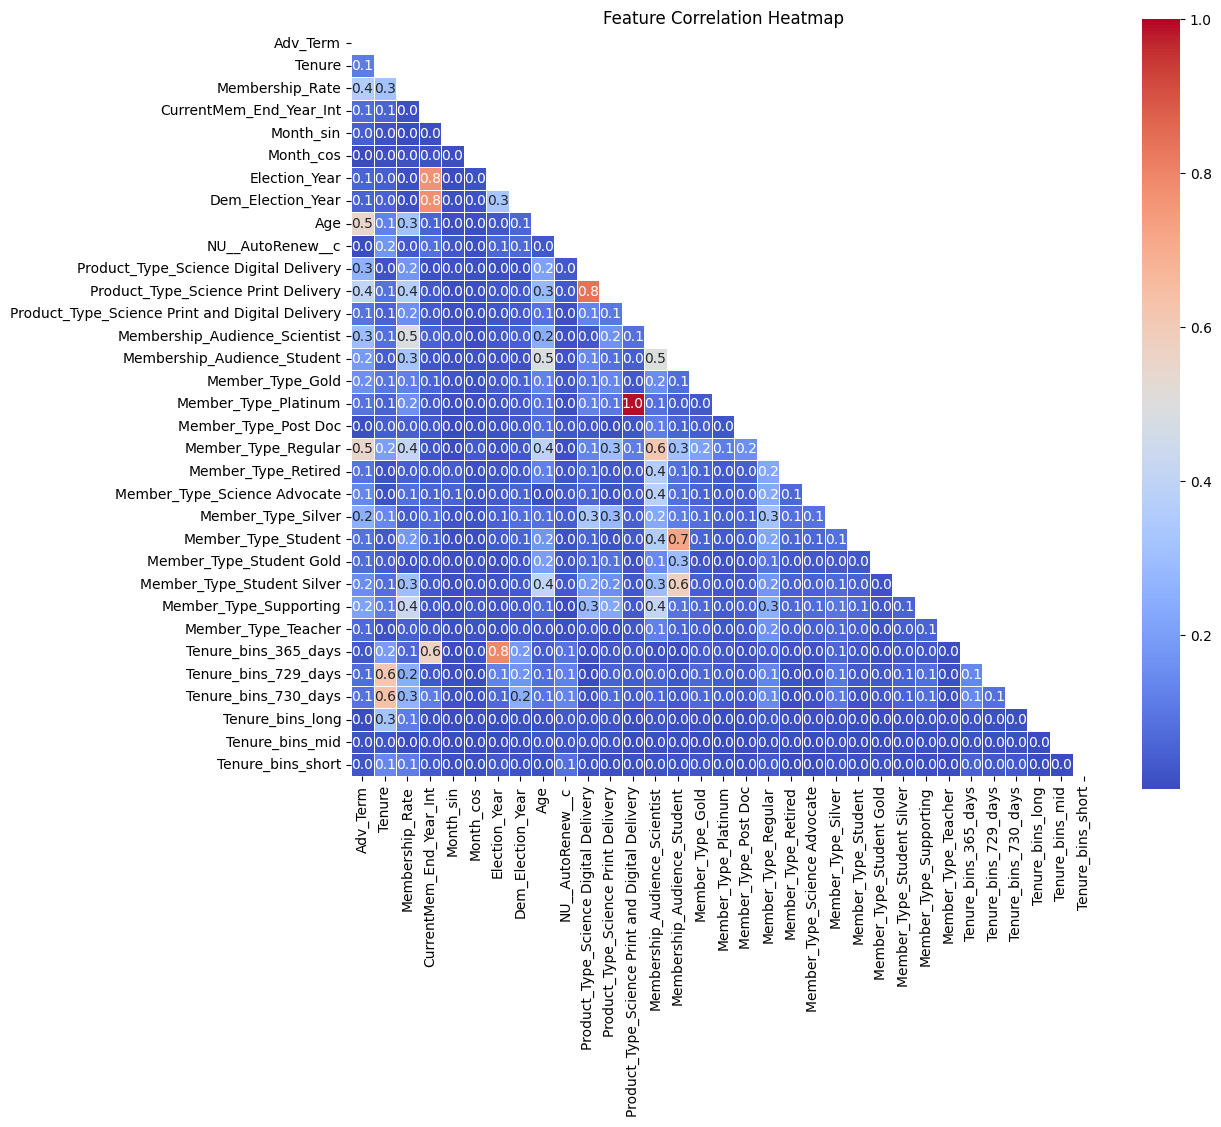

In [151]:
data = MBR_budget_pre_2025_processed_modeling_final
data_dummies = pd.get_dummies(data[['Adv_Term','Tenure','Product_Type','Membership_Audience','Membership_Rate',
    'CurrentMem_End_Year_Int', 'Month_sin', 'Month_cos','Election_Year','Member_Type','Dem_Election_Year',
    'Tenure_bins','Age','NU__AutoRenew__c'
    ]], drop_first=True)
corr = data_dummies.corr().abs()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".1f", vmax=1.0, square=True, linewidths=.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [152]:
# Removed Member_Type, Tenure, CurrentMem_End_Year_Int, Election_Year, and Product_Type due to high correlation with other features
# Need to drop more dummies after OHE
MBR_budget_pre_2025_processed_modeling_final = MBR_budget_pre_2025_processed_modeling_final[[
       'NU__AutoRenew__c', 
       'KeyCode__c',
       'Adv_Term', 
       'Membership_Rate',
       'Renewed', # outcome variable
       'TermGroupChanged', 
       'CurrentMem_End_Month', # this is an integer
       'Term_Group',
       'Tenure_bins',
       'Membership_Audience',
       'Age',
       'Month_sin',
       'Month_cos',
       # 'Election_Year',
       'Dem_Election_Year',
       # 'RenewalDaysUntilExpiry',
       # 'RenewalDaysUntilExpiry_bins'
       'DaysSinceJoined'
       ]] 

mask = (MBR_budget_pre_2025_processed_modeling_final['Adv_Term'] == 1) & (MBR_budget_pre_2025_processed_modeling_final['NU__AutoRenew__c'] == False)
MBR_budget_pre_2025_processed_modeling_final['is_term1_no_auto'] = False
MBR_budget_pre_2025_processed_modeling_final.loc[mask, 'is_term1_no_auto'] = True

MBR_budget_pre_2025_processed_modeling_final['term_and_auto_renew'] = MBR_budget_pre_2025_processed_modeling_final['Adv_Term'] * MBR_budget_pre_2025_processed_modeling_final['NU__AutoRenew__c']

MBR_budget_pre_2025_processed_modeling_final['Age'] = MBR_budget_pre_2025_processed_modeling_final['Age'].fillna(value=999)

assert len(MBR_budget_pre_2025_processed_modeling_final) == len(MBR_budget_pre_2025_processed)
MBR_budget_pre_2025_processed_modeling_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305134 entries, 0 to 305133
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NU__AutoRenew__c      305134 non-null  bool   
 1   KeyCode__c            286570 non-null  object 
 2   Adv_Term              305134 non-null  int32  
 3   Membership_Rate       305134 non-null  float64
 4   Renewed               305134 non-null  Int32  
 5   TermGroupChanged      305134 non-null  object 
 6   CurrentMem_End_Month  305134 non-null  int32  
 7   Term_Group            305134 non-null  object 
 8   Tenure_bins           305134 non-null  object 
 9   Membership_Audience   305134 non-null  object 
 10  Age                   305134 non-null  Int64  
 11  Month_sin             305134 non-null  float64
 12  Month_cos             305134 non-null  float64
 13  Dem_Election_Year     305134 non-null  int64  
 14  DaysSinceJoined       305134 non-null  float64
 15  

C:\Users\ybai\AppData\Local\Temp\ipykernel_5164\3253740579.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MBR_budget_pre_2025_processed_modeling_final['is_term1_no_auto'] = False
C:\Users\ybai\AppData\Local\Temp\ipykernel_5164\3253740579.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MBR_budget_pre_2025_processed_modeling_final['term_and_auto_renew'] = MBR_budget_pre_2025_processed_modeling_final['Adv_Term'] * MBR_budget_pre_2025_processed_modeling_final['NU__AutoRenew__c']
C:\Users\ybai\AppData

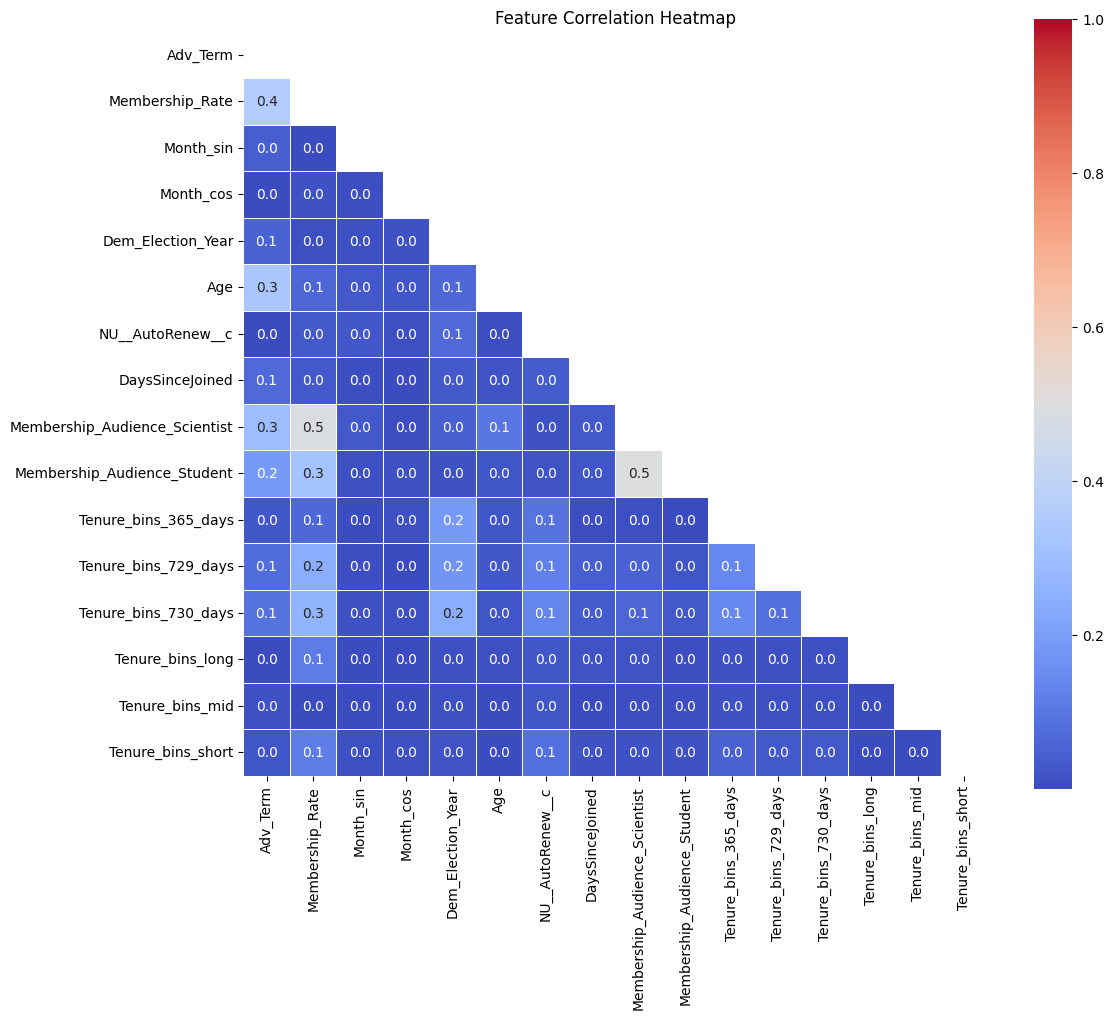

In [153]:
data = MBR_budget_pre_2025_processed_modeling_final
data_dummies = pd.get_dummies(data[['Adv_Term','Membership_Audience','Membership_Rate',
    'Month_sin', 'Month_cos','Dem_Election_Year', 'Tenure_bins','Age','NU__AutoRenew__c','DaysSinceJoined'
    ]], drop_first=True)
corr = data_dummies.corr().abs()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".1f", vmax=1.0, square=True, linewidths=.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [154]:
# Add features to inference data
MBR_budget_2025_2026_processed_inference = process_data_add_feature(MBR_budget_2025_2026_processed)
MBR_budget_2025_2026_processed_inference_final = MBR_budget_2025_2026_processed_inference.copy()

# Final inference dataset
MBR_budget_2025_2026_processed_inference_final = MBR_budget_2025_2026_processed_inference_final[[
       'NU__AutoRenew__c', 
       'KeyCode__c',
       'Adv_Term', 
       'Membership_Rate',
       'Renewed', # outcome variable
       'TermGroupChanged', 
       'CurrentMem_End_Month', # this is an integer
       'Term_Group',
       'Tenure_bins',
       'Membership_Audience',
       'Age',
       'Month_sin',
       'Month_cos',
       # 'Election_Year',
       'Dem_Election_Year',
       'DaysSinceJoined'
       # 'RenewalDaysUntilExpiry',
       # 'RenewalDaysUntilExpiry_bins'
       ]]

mask = (MBR_budget_2025_2026_processed_inference_final['Adv_Term'] == 1) & (MBR_budget_2025_2026_processed_inference_final['NU__AutoRenew__c'] == False)
MBR_budget_2025_2026_processed_inference_final['is_term1_no_auto'] = False
MBR_budget_2025_2026_processed_inference_final.loc[mask, 'is_term1_no_auto'] = True

MBR_budget_2025_2026_processed_inference_final['term_and_auto_renew'] = MBR_budget_2025_2026_processed_inference_final['Adv_Term'] * MBR_budget_2025_2026_processed_inference_final['NU__AutoRenew__c']

MBR_budget_2025_2026_processed_inference_final['Age'] = MBR_budget_2025_2026_processed_inference_final['Age'].fillna(value=999)

assert len(MBR_budget_2025_2026_processed_inference_final) == len(MBR_budget_2025_2026_processed)
assert len(MBR_budget_pre_2025_processed_modeling_final.columns) == len(MBR_budget_2025_2026_processed_inference_final.columns)
MBR_budget_2025_2026_processed_inference_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100330 entries, 0 to 100329
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NU__AutoRenew__c      100330 non-null  bool   
 1   KeyCode__c            99433 non-null   object 
 2   Adv_Term              100330 non-null  int32  
 3   Membership_Rate       100330 non-null  float64
 4   Renewed               100330 non-null  Int32  
 5   TermGroupChanged      100330 non-null  object 
 6   CurrentMem_End_Month  100330 non-null  int32  
 7   Term_Group            100330 non-null  object 
 8   Tenure_bins           100330 non-null  object 
 9   Membership_Audience   100330 non-null  object 
 10  Age                   100330 non-null  Int64  
 11  Month_sin             100330 non-null  float64
 12  Month_cos             100330 non-null  float64
 13  Dem_Election_Year     100330 non-null  int64  
 14  DaysSinceJoined       100330 non-null  float64
 15  

### Save data for Sagemaker

In [155]:
# RenewalCurve_type2_modeling.to_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\renewal_forecast_sagemaker_data_SP2025\Renewal_Forecast_main_dataset_250403.csv", index=False)
# ref_data_final_modeling.to_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\renewal_forecast_sagemaker_data_SP2025\Renewal_Forecast_ref_dataset_250403.csv", index=False)
# RenewalCurve_type2_modeling.to_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\renewal_forecast_sagemaker_data_SP2025\Renewal_Forecast_main_dataset_250602.csv", index=False)
# ref_data_final_modeling.to_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\renewal_forecast_sagemaker_data_SP2025\Renewal_Forecast_ref_dataset_250602.csv", index=False)

MBR_budget_pre_2025_processed_modeling_final.to_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\Renewals Forecast\Sagemaker Renewal Modeling 2025-26\renewal_forecast_sagemaker_data_SP2025\Renewal_Forecast_individual_modeling_dataset_FINAL_250703_v2.csv", index=False)
MBR_budget_2025_2026_processed_inference_final.to_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\Renewals Forecast\Sagemaker Renewal Modeling 2025-26\renewal_forecast_sagemaker_data_SP2025\Renewal_Forecast_individual_inference_dataset_FINAL_250703_v2.csv", index=False)

## Modeling and model drift detection (no more data cleaning or feature eng after this)

https://www.evidentlyai.com/blog/evidently-016-regression-model-performance 

https://medium.com/@pumaline/easy-analysis-of-your-data-and-ml-model-using-evidently-ai-830ef0c1c4fd

### Check version of modules

In [156]:
print(f"Pandas version: {pd.__version__}") #2.2.3
print(f"Sklearn version: {sklearn.__version__}") #1.2.1

Pandas version: 2.2.3
Sklearn version: 1.2.1


## All data - using Random Forest

#### One-hot encoding and Target encoding (for keycode)

In [ ]:
def fit_combined_encoder(dataframe, outcome_col='Renewed', large_cat_col='KeyCode__c', smoothing=10):
    """
    Fits encoders:
    - TargetEncoder for large cardinality feature (e.g., campaign code)
    - OneHotEncoder for all other categorical features

    Returns:
        y: target column
        target_encoder: fitted TargetEncoder
        ohe_encoder: fitted ColumnTransformer with OneHotEncoder
        categorical_features: list of categorical features used in OHE
    """
    df = dataframe.copy()
    y = df[outcome_col].copy()

    # Fit TargetEncoder
    target_encoder = TargetEncoder(cols=[large_cat_col], smoothing=smoothing)
    target_encoder.fit(df[[large_cat_col]], y)

    # Get categorical features (excluding outcome and large cardinality column)
    df_for_ohe = df.drop(columns=[outcome_col, large_cat_col])
    categorical_features = df_for_ohe.select_dtypes(include=['object', 'category']).columns.tolist()
    print("OHE categorical features:", categorical_features)

    # Fit OneHotEncoder
    ohe_encoder = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )
    ohe_encoder.fit(df_for_ohe)

    return y, target_encoder, ohe_encoder, categorical_features

In [ ]:
def transform_with_encoder(dataframe, outcome_col='Renewed', large_cat_col='KeyCode__c', target_encoder=None, ohe_encoder=None):
    """
    Transforms the dataframe using fitted encoders.
    Returns:
        X_encoded: final transformed feature matrix
        y: target column (if present)
    """
    df = dataframe.copy()
    y = df[outcome_col].copy() if outcome_col in df.columns else None

    # Apply Target Encoding
    df_keycode_encoded = target_encoder.transform(df[[large_cat_col]])

    # Prepare data for OHE
    df_for_ohe = df.drop(columns=[outcome_col, large_cat_col], errors='ignore')
    X_ohe = ohe_encoder.transform(df_for_ohe)
    ohe_feature_names = ohe_encoder.get_feature_names_out()

    # Combine encoded features
    X_encoded = pd.concat([
        df_keycode_encoded.reset_index(drop=True),
        pd.DataFrame(X_ohe, columns=ohe_feature_names)
    ], axis=1)

    assert 'remainder__Renewed' not in X_encoded.columns, "Error! Outcome label in training dataset"

    return X_encoded, y


#### Run RF model

##### Training data

In [ ]:
# define datasets
data_20, _ = train_test_split(
    MBR_budget_pre_2025_processed_modeling_final,
    test_size=.8,
    stratify=MBR_budget_pre_2025_processed_modeling_final['is_term1_no_auto'],
    random_state=42
) # sample 20% of data to estimate model runtime
data = MBR_budget_pre_2025_processed_modeling_final # use data before 2025 for training
data=data_20

# Split into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Renewed'])

# Fit encoders on training data only
y_train, target_encoder, ohe_encoder, _ = fit_combined_encoder(train_df)

# Transform training and test data
X_train, y_train = transform_with_encoder(train_df, target_encoder=target_encoder, ohe_encoder=ohe_encoder)
X_test, y_test = transform_with_encoder(test_df, target_encoder=target_encoder, ohe_encoder=ohe_encoder)

# get outcome label for test data - y_train was developed in the fit_combined_encoder function
# y_test = test_df['Renewed'].copy()

# add sample weights
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

In [ ]:
# Initialize and train+finetune a Random Forest model
rf = RandomForestClassifier(
    random_state=42,
    class_weight=None,
    n_jobs=-1
)

param_grid = {
    'max_depth': [10,20],
    'max_features': ['sqrt','log2'],
    'min_samples_leaf': [1,2,5],
    'min_samples_split': [2,5,10],
    'n_estimators': [150,300]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train, **{'sample_weight': sample_weight})  # Binary classification training


In [ ]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)

In [ ]:
y_pred = grid_search.predict(X_test)        # Get 0/1 predictions
y_pred_proba = grid_search.predict_proba(X_test)

In [ ]:
# Precision, Recall, F1
precision = precision_score(y_test, y_pred) # true positive out of all positives
recall = recall_score(y_test, y_pred) # true positives out of all data
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(classification_report(y_test, y_pred))

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['Not Renewed', 'Renewed'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Renewal Projections')
plt.grid(False)
plt.show()

# Print metrics derived from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.3f}")
print(f"Precision: {tp / (tp + fp):.3f}")
print(f"Recall: {tp / (tp + fn):.3f}")
print(f"F1 Score: {2 * tp / (2 * tp + fp + fn):.3f}")

In [ ]:
# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
best_rf_model = grid_search.best_estimator_
# joblib.dump(best_rf_model, r"C:\Users\ybai\OneDrive - AAAS\Desktop\best_rf_model_rocauc_0615.lib")

In [ ]:
# see feature importance
def plot_feature_importance(best_model, feature_names, top_n=20):
    """
    Plots top N feature importances from a trained RandomForest model.

    Parameters:
        model (RandomForestClassifier): Trained RF model
        feature_names (list or array): Names of input features
        top_n (int): Number of top features to plot
    """

    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(
        feature_importance_df['Feature'][::-1],  # Reverse for top-down
        feature_importance_df['Importance'][::-1],
        color='skyblue'
    )
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_rf_model, X_train.columns, top_n=30)

##### Final budget projections

In [ ]:
# Get dataset for budget projections (2025-26 data)
# MBR_budget_2025_2026_processed_inference_final

# define datasets
data_10 = MBR_budget_2025_2026_processed_inference_final.sample(frac=0.1, random_state=42) # sample 10% of data to estimate model runtime
data = MBR_budget_2025_2026_processed_inference_final

X_inference, _ = transform_with_encoder(
    data,
    outcome_col='Renewed',
    target_encoder=target_encoder,
    ohe_encoder=ohe_encoder
)

In [ ]:
# predict
y_inference_pred = grid_search.predict(X_inference)
y_inference_pred_proba = grid_search.predict_proba(X_inference)

In [ ]:
inference_results = data.copy()
inference_results['PredictedRenewed'] = y_inference_pred
inference_results['PredictedRenewedProba'] = y_inference_pred_proba[:, 1]

In [ ]:
MBR_budget_2025_2026['PredictedRenewed'] = y_inference_pred
MBR_budget_2025_2026['PredictedRenewedProba'] = y_inference_pred_proba[:, 1]
display(MBR_budget_2025_2026)

In [ ]:
MBR_budget_2025_2026.reset_index(drop=True).to_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\Renewal_Forecast_budget_projections_FINAL_250605.csv", index=False)

## XGBoost

In [157]:
xgb_train_data = MBR_budget_pre_2025_processed_modeling_final.copy()
# xgb_data = xgb_data.drop(columns='Renewed')

for i in xgb_train_data.columns:
    if xgb_train_data[i].dtype == 'object':
        xgb_train_data[i] = xgb_train_data[i].astype('category')
    # Convert datetime types to int (timestamp) - if any
    # elif xgb_train_data[i].dtype == 'bool':
    #     xgb_train_data[i] = xgb_train_data[i].astype(float)
    elif pd.api.types.is_datetime64_dtype(xgb_train_data[i]):
        xgb_train_data[i] = xgb_train_data[i].astype(np.int64) // 10**9 
    elif not (pd.api.types.is_integer_dtype(xgb_train_data[i]) or 
              pd.api.types.is_float_dtype(xgb_train_data[i])):
        xgb_train_data[i] = xgb_train_data[i].astype(float)

xgb_train_data_final = xgb_train_data

xgb_train_data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305134 entries, 0 to 305133
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   NU__AutoRenew__c      305134 non-null  float64 
 1   KeyCode__c            286570 non-null  category
 2   Adv_Term              305134 non-null  int32   
 3   Membership_Rate       305134 non-null  float64 
 4   Renewed               305134 non-null  Int32   
 5   TermGroupChanged      305134 non-null  category
 6   CurrentMem_End_Month  305134 non-null  int32   
 7   Term_Group            305134 non-null  category
 8   Tenure_bins           305134 non-null  category
 9   Membership_Audience   305134 non-null  category
 10  Age                   305134 non-null  Int64   
 11  Month_sin             305134 non-null  float64 
 12  Month_cos             305134 non-null  float64 
 13  Dem_Election_Year     305134 non-null  int64   
 14  DaysSinceJoined       305134 non-nul

In [158]:
# construct datasets for xgb
xgb_train, xgb_test = train_test_split(xgb_train_data_final, test_size=0.2, random_state=42, stratify=xgb_train_data_final['Renewed'])
xgb_train, xgb_val = train_test_split(xgb_train, test_size=0.2, random_state=42, stratify = xgb_train['Renewed'])

xgb_train_x, xgb_train_y = xgb_train.drop(columns='Renewed').reset_index(drop=True), xgb_train['Renewed'].reset_index(drop=True)
xgb_val_x, xgb_val_y = xgb_val.drop(columns='Renewed').reset_index(drop=True), xgb_val['Renewed'].reset_index(drop=True)

xgb_train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195285 entries, 0 to 195284
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   NU__AutoRenew__c      195285 non-null  float64 
 1   KeyCode__c            183380 non-null  category
 2   Adv_Term              195285 non-null  int32   
 3   Membership_Rate       195285 non-null  float64 
 4   TermGroupChanged      195285 non-null  category
 5   CurrentMem_End_Month  195285 non-null  int32   
 6   Term_Group            195285 non-null  category
 7   Tenure_bins           195285 non-null  category
 8   Membership_Audience   195285 non-null  category
 9   Age                   195285 non-null  Int64   
 10  Month_sin             195285 non-null  float64 
 11  Month_cos             195285 non-null  float64 
 12  Dem_Election_Year     195285 non-null  int64   
 13  DaysSinceJoined       195285 non-null  float64 
 14  is_term1_no_auto      195285 non-nul

In [ ]:
# make D.matrix for xgboost - no need for now
# dtrain = xgb.DMatrix(
#     data=xgb_train_x, 
#     label=xgb_train_y,
#     enable_categorical=True
# )

# dtest = xgb.Dmatrix(
#     data=xgb_test_x,
#     label=xgb_test_y,
#     enable_categorical=True
# )

In [ ]:
# Train model from scratch
# from sklearn.metrics import make_scorer, f1_score

# xgb_model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='auc',
#     use_label_encoder=False,
#     enable_categorical=True,
#     random_state=42,
#     n_jobs=-1
# )

# scale_pos_weight = (xgb_train_y == 0).sum()/(xgb_train_y == 1).sum()

# # param_grid = {
# #     'n_estimators': [100, 500, 1000],
# #     'max_depth': [3, 5, 7],
# #     'learning_rate': [0.01, 0.05, 0.1],
# #     'subsample': [0.8],
# #     'colsample_bytree': [0.8],
# #     'scale_pos_weight': [scale_pos_weight],  # adjust based on class imbalance
# #     'gamma': [0, 1, 4]
# #     # 'booster':['gbtree', 'dart']
# # }

# scorer = make_scorer(f1_score, pos_label=1)

# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring=scorer,
#     cv=5,
#     verbose=3,
#     n_jobs=-1
# )


# # grid_search.fit(xgb_train_x, xgb_train_y)

# # Best model
# best_model = grid_search.best_estimator_
# print("Best Params:", grid_search.best_params_)

In [159]:
# After running full XGB model and getting best model parameters:
scale_pos_weight = (xgb_train_y == 0).sum()/(xgb_train_y == 1).sum()

model = xgb.XGBClassifier(
    enable_categorical=True,
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,  # avoid label encoder warning
    n_estimators=500,
    max_depth=7,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    # early_stopping_rounds=100,
    random_state=42,
    n_jobs=-1
)

# early_stop = xgb.callback.EarlyStopping(
#     rounds=100,
#     min_delta=0.001,
#     metric_name='auc',
#     data_name=xgb_val_x,
#     save_best=True
# )

model.fit(xgb_train_x, xgb_train_y,
          eval_set=[(xgb_train_x, xgb_train_y), (xgb_val_x, xgb_val_y)],
          verbose=100
          )

[0]	validation_0-auc:0.84105	validation_1-auc:0.83519


c:\Users\ybai\AppData\Local\anaconda3\envs\sagemaker_renforecast_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:27:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-auc:0.98619	validation_1-auc:0.98593
[200]	validation_0-auc:0.98727	validation_1-auc:0.98669
[300]	validation_0-auc:0.98841	validation_1-auc:0.98741
[400]	validation_0-auc:0.98937	validation_1-auc:0.98800
[499]	validation_0-auc:0.99009	validation_1-auc:0.98841


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [160]:
# xgb test data for prediction
xgb_test_x = xgb_test.drop('Renewed', axis=1)
xgb_test_y = xgb_test['Renewed']
assert ('Renewed' in xgb_test_x.columns.to_list()) == False

In [ ]:
# y_pred = grid_search.predict(xgb_test_x)
# precision = precision_score(xgb_test_y, y_pred)
# recall = recall_score(xgb_test_y, y_pred)
# f1 = f1_score(xgb_test_y, y_pred)
# print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

# print("Classification Report:")
# print(classification_report(xgb_test_y, y_pred, digits=3))

In [161]:
y_pred = model.predict(xgb_test_x)
precision = precision_score(xgb_test_y, y_pred)
recall = recall_score(xgb_test_y, y_pred)
f1 = f1_score(xgb_test_y, y_pred)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

print("Classification Report:")
print(classification_report(xgb_test_y, y_pred, digits=3))

Precision: 0.980, Recall: 0.955, F1 Score: 0.967
Classification Report:
              precision    recall  f1-score   support

         0.0      0.873     0.939     0.905     15018
         1.0      0.980     0.955     0.967     46009

    accuracy                          0.951     61027
   macro avg      0.926     0.947     0.936     61027
weighted avg      0.953     0.951     0.952     61027



In [ ]:
# Tune threshold with predict_proba - prioritize precision and recall for class 1
# y_pred_proba = pd.DataFrame(grid_search.predict_proba(xgb_test_x)[:, 1], colnames=['PredictProba'])
# y_pred_proba
# precision = precision_score(xgb_test_y, y_pred_proba) # true positive out of all positives
# recall = recall_score(xgb_test_y, MBR_budget_2025_2026['PredictedRenewed_tuned']) # true positives out of all data
# f1 = f1_score(xgb_test_y, MBR_budget_2025_2026['PredictedRenewed_tuned'])

# print(f"Precision: {precision:.2f}")
# print(f"Recall:    {recall:.2f}")
# print(f"F1 Score:  {f1:.2f}")
# print(classification_report(MBR_budget_2025_2026['Renewed'], MBR_budget_2025_2026['PredictedRenewed_tuned']))

In [162]:
# train model on full dataset to predict on future data
xgb_train_full = xgb_train_data_final.copy()
xgb_train_full_x = xgb_train_full.drop(columns='Renewed',axis=1)
xgb_train_full_y = xgb_train_full['Renewed']
assert 'Renewed' not in xgb_train_full_x.columns, "Error! Output label in training dataset"

# best_params = grid_search.best_params_
best_params = model.get_params()
final_xgb_model = xgb.XGBClassifier(
    **best_params
)
final_xgb_model.fit(xgb_train_full_x, xgb_train_full_y)


c:\Users\ybai\AppData\Local\anaconda3\envs\sagemaker_renforecast_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:28:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [163]:
joblib.dump(final_xgb_model, r"C:\Users\ybai\OneDrive - AAAS\Desktop\xgboost_model_rendaysuntilexpire_250703_v2.joblib")
print("Saved results to disk.")

Saved results to disk.


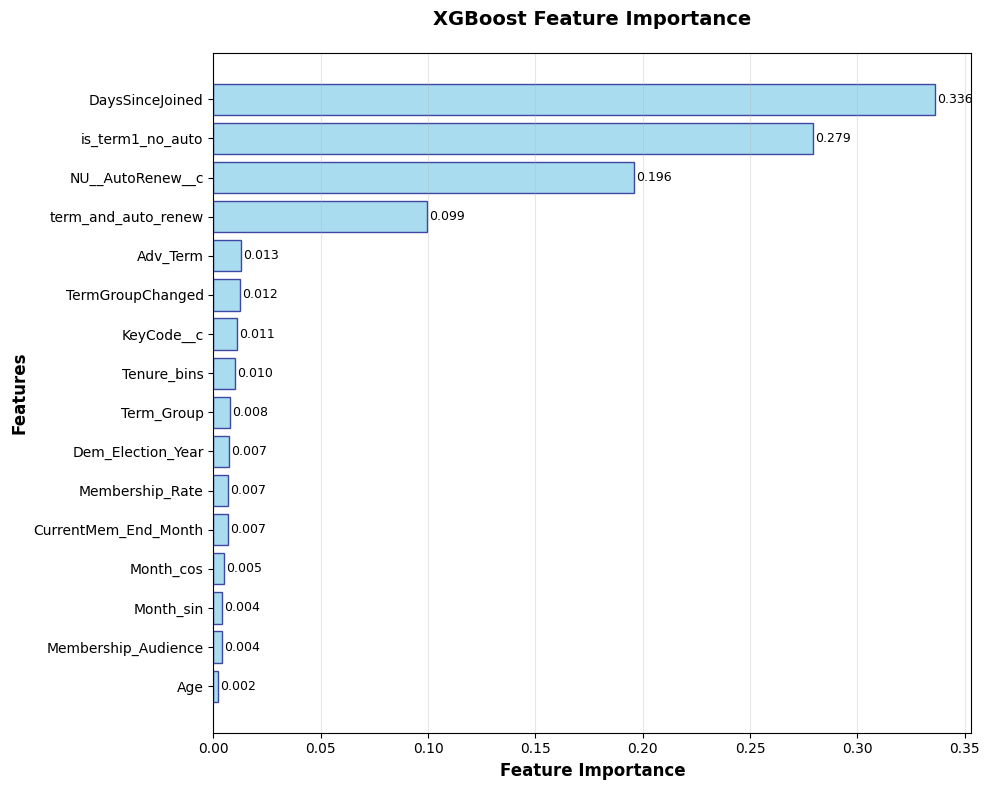

In [164]:
# Plot feature importance
feature_names = model.feature_names_in_
feature_importance = model.feature_importances_

feature_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Create the plot
plt.figure(figsize=(10, 8))
bars = plt.barh(feature_df['feature'], feature_df['importance'], color='skyblue', edgecolor='navy', alpha=0.7)

# Customize the plot
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold', pad=20)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# Improve layout
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

In [168]:
# SHAP values
model = final_xgb_model
le = LabelEncoder()
cat_cols = xgb_train_full.select_dtypes(include=['category']).columns
for col in cat_cols:
    xgb_train_full[col] = le.fit_transform(xgb_train_full[col])

dtest = xgb.DMatrix(xgb_train_full)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest)
baseline_value = explainer.expected_value

shap.summary_plot(shap_values, xgb_train_full, feature_names=xgb_train_full.columns)

XGBoostError: [17:56:29] C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (5492412 vs. 5187278) : 

In [119]:
xgb_inf_data = MBR_budget_2025_2026_processed_inference_final.copy()
# get final columns for xgb_train_data
xgb_inf_data_final = xgb_inf_data[[
       'NU__AutoRenew__c', 
       'KeyCode__c',
       'Adv_Term', 
       'Membership_Rate',
       'Renewed', # outcome variable
       'TermGroupChanged', 
       'CurrentMem_End_Month', # this is an integer
       'Term_Group',
       'Tenure_bins',
       'Membership_Audience',
       'Age',
       'Month_sin',
       'Month_cos',
    #    'Election_Year',
       'Dem_Election_Year',
       'DaysSinceJoined',
    #    'RenewalDaysUntilExpiry',
    #    'RenewalDaysUntilExpiry_bins',
       'is_term1_no_auto',
       'term_and_auto_renew'
       ]]
for i in xgb_inf_data_final.columns:
    if xgb_inf_data_final[i].dtype == 'object':
        xgb_inf_data_final[i] = xgb_inf_data_final[i].astype('category')
    # Convert datetime types to int (timestamp) - if any
    # elif xgb_train_data[i].dtype == 'bool':
    #     xgb_train_data[i] = xgb_train_data[i].astype(float)
    elif xgb_inf_data_final[i].dtype == 'category':
        pass
    elif pd.api.types.is_datetime64_dtype(xgb_inf_data_final[i]):
        xgb_inf_data_final[i] = xgb_inf_data_final[i].astype(np.int64) // 10**9 
    elif not (pd.api.types.is_integer_dtype(xgb_inf_data_final[i]) or 
              pd.api.types.is_float_dtype(xgb_inf_data_final[i])):
        xgb_inf_data_final[i] = xgb_inf_data_final[i].astype(float)

In [121]:
members_to_predict = xgb_inf_data_final[xgb_inf_data_final['Renewed'] == 0]
members_already_renewed = xgb_inf_data_final[xgb_inf_data_final['Renewed'] == 1]
MBR_budget_2025_2026_renewed, MBR_budget_2025_2026_predict = MBR_budget_2025_2026[MBR_budget_2025_2026['Renewed'] == 1], MBR_budget_2025_2026[MBR_budget_2025_2026['Renewed'] == 0]

# get final predictions for budgets
xgb_inf_without_y = members_to_predict.drop(columns='Renewed', axis=1)
y_inference_pred = final_xgb_model.predict(xgb_inf_without_y)
# y_inference_pred_proba = grid_search.predict_proba(xgb_inf_without_y)
y_inference_pred_proba = final_xgb_model.predict_proba(xgb_inf_without_y)

data = members_to_predict
inference_results = data.copy()

inference_results['PredictedRenewed'] = y_inference_pred
inference_results['PredictedRenewedProba'] = y_inference_pred_proba[:, 1]

MBR_budget_2025_2026_predict['PredictedRenewed'] = y_inference_pred
MBR_budget_2025_2026_predict['PredictedRenewedProba'] = y_inference_pred_proba[:, 1]
MBR_budget_2025_2026_predict['PredictedRenewed_tuned'] = (MBR_budget_2025_2026_predict['PredictedRenewedProba'] > 0.5).astype(int)

MBR_budget_2025_2026_renewed['PredictedRenewed'] = 1
MBR_budget_2025_2026_renewed['PredictedRenewedProba'] = 0.99
MBR_budget_2025_2026_renewed['PredictedRenewed_tuned'] = 1

display(MBR_budget_2025_2026_predict)

C:\Users\ybai\AppData\Local\Temp\ipykernel_5164\601895026.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MBR_budget_2025_2026_predict['PredictedRenewed'] = y_inference_pred
C:\Users\ybai\AppData\Local\Temp\ipykernel_5164\601895026.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MBR_budget_2025_2026_predict['PredictedRenewedProba'] = y_inference_pred_proba[:, 1]
C:\Users\ybai\AppData\Local\Temp\ipykernel_5164\601895026.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,CustomerNumber__c,NU__AutoRenew__c,Email,Member_Type,KeyCode__c,CurrentMem_Start_Date,CurrentMem_End_Date,OrderDate,Prev_Term_End_Date,NextMem_Start_Date,...,RenewalDaysUntilExpiry_bins,TermGroupChanged,Term_Group,CurrentMem_End_Month,CurrentMem_End_Month_Name,CurrentMem_End_Year_Int,CurrentMem_End_Year,PredictedRenewed,PredictedRenewedProba,PredictedRenewed_tuned
1,00000744,False,kevinkeough@shaw.ca,Student Gold,R1510RWBEP,2025-06-01,2026-05-31,2025-05-29,2025-01-31,NaT,...,regular,Term 4+,Term 4+,5,May,2026,2026,1,0.982728,1
2,00000884,True,hsgaskill@mun.ca,Emeritus,AUTOREN,2024-08-01,2025-07-31,2024-05-31,2024-07-31,NaT,...,regular,Term 4+,Term 4+,7,July,2025,2025,1,0.966661,1
4,00001449,False,eljgj@eastlink.ca,Regular,R252ESPD,2025-03-01,2026-02-28,2024-11-07,2025-02-28,NaT,...,regular,Term 4+,Term 4+,2,February,2026,2026,1,0.975760,1
6,00002127,False,m.w.gray@dal.ca,Emeritus,R442ESAD,2024-05-01,2025-04-30,2024-01-01,2024-04-30,NaT,...,regular,Term 4+,Term 4+,4,April,2025,2025,1,0.974028,1
7,00002909,True,oceans2@ns.sympatico.ca,Regular,AUTOREN,2024-11-01,2025-10-31,2024-08-29,2024-10-31,NaT,...,regular,Term 4+,Term 4+,10,October,2025,2025,1,0.971262,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100325,61013559,True,rsberryslc@gmail.com,Supporting,P25GB2,2025-07-01,2026-06-30,2025-07-02,NaT,NaT,...,regular,Term 1,Term 1,6,June,2026,2026,1,0.980414,1
100326,61013643,False,candylandau@gmail.com,Gold,P24PO4,2025-07-01,2026-06-30,2025-07-02,NaT,NaT,...,regular,Term 1,Term 1,6,June,2026,2026,1,0.968573,1
100327,61013707,True,hyukjunl@sogang.ac.kr,Gold,P24SMT,2025-07-01,2026-06-30,2025-07-02,NaT,NaT,...,regular,Term 1,Term 1,6,June,2026,2026,1,0.984498,1
100328,61013797,False,malelang.s@wehi.edu.au,Student Silver,P24SMT,2025-07-01,2026-06-30,2025-07-03,NaT,NaT,...,regular,Term 1,Term 1,6,June,2026,2026,1,0.950716,1


# Pivot dataset to match budgeting sheet

In [122]:
df = pd.concat([MBR_budget_2025_2026_predict, MBR_budget_2025_2026_renewed], axis=0)
assert len(df) == len(MBR_budget_2025_2026_predict) + len(MBR_budget_2025_2026_renewed)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100330 entries, 1 to 99934
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   CustomerNumber__c            100330 non-null  object        
 1   NU__AutoRenew__c             100330 non-null  bool          
 2   Email                        100330 non-null  object        
 3   Member_Type                  100330 non-null  object        
 4   KeyCode__c                   99433 non-null   object        
 5   CurrentMem_Start_Date        100330 non-null  datetime64[ns]
 6   CurrentMem_End_Date          100330 non-null  datetime64[ns]
 7   OrderDate                    100330 non-null  datetime64[ns]
 8   Prev_Term_End_Date           87730 non-null   datetime64[ns]
 9   NextMem_Start_Date           28327 non-null   datetime64[ns]
 10  NextMem_End_Date             28327 non-null   datetime64[ns]
 11  Next_Order_Created_Date      283

In [123]:
df.rename(columns={
    'PredictedRenewed': 'Renewal_Binary',
    'CustomerNumber__c': 'Customer_Number',
    'CurrentMem_End_Month': 'CurrentMem_EndMonth',
    'CurrentMem_End_Year': 'Exp_Year',
    'Member_Type': 'Member_Type',
    'Product_Type': 'Product_Type'
    }, inplace=True)

# df['Auto_Renew'] = df['Auto_Renew'].astype(str)

group_fields = [
    'CurrentMem_EndMonth',
    'Exp_Year',
    'TermGroupChanged',
    'Member_Type',
    'NU__AutoRenew__c',
    'Term_Group',
    'Product_Type'
]

In [124]:
print(df.columns.tolist())

['Customer_Number', 'NU__AutoRenew__c', 'Email', 'Member_Type', 'KeyCode__c', 'CurrentMem_Start_Date', 'CurrentMem_End_Date', 'OrderDate', 'Prev_Term_End_Date', 'NextMem_Start_Date', 'NextMem_End_Date', 'Next_Order_Created_Date', 'Tenure', 'Adv_Term', 'Membership_Status', 'Product_Type', 'Membership_Rate', 'Renewed', 'Membership_Audience', 'Election_Year', 'Post_Election_Year', 'Dem_Election_Year', 'Age', 'Month_sin', 'Month_cos', 'RenewalDate', 'Next_Term', 'Term_Diff', 'RenewalDaysUntilExpiry', 'RenewalDaysUntilExpiry_bins', 'TermGroupChanged', 'Term_Group', 'CurrentMem_EndMonth', 'CurrentMem_End_Month_Name', 'CurrentMem_End_Year_Int', 'Exp_Year', 'Renewal_Binary', 'PredictedRenewedProba', 'PredictedRenewed_tuned']


In [125]:
agg_df = df.groupby(group_fields).agg(
    Forecasted_Renewal_Income=pd.NamedAgg(column='Membership_Rate', aggfunc=lambda x: round((np.exp(x) * df.loc[x.index, 'Renewal_Binary']).sum(), 2)),
    Renewed=pd.NamedAgg(column='Renewed', aggfunc='sum'),
    Forecasted_Renewals=pd.NamedAgg(column='Renewal_Binary', aggfunc='sum'),
    Renewal_Pool=pd.NamedAgg(column='Customer_Number', aggfunc='count')
).reset_index()

In [126]:
agg_df['Month'] = agg_df['CurrentMem_EndMonth'].apply(lambda x: calendar.month_name[x])

agg_df.columns

agg_df = agg_df[['Month', 'Exp_Year', 'TermGroupChanged','NU__AutoRenew__c', 
       'Member_Type', 'Term_Group','Product_Type', 
       'Forecasted_Renewal_Income', 'Renewed', 'Forecasted_Renewals',
       'Renewal_Pool']]

In [127]:
# Get final aggregate dataset for budgeting
agg_df.reset_index(drop=True).to_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\Renewal_Forecast_budget_projections_aggregate_FINAL_250703.csv", index=False)

## Split Current and Ref data - Current is 3 months ago from "today". Ref is all data after that

For drift detection only. Reassess which dataset to use for splitting.

In [ ]:
# split ref and current data
today = datetime.today()
mask = RenewalCurve_type2['CurrentMem_End_Date'] <= today - relativedelta(months=3)
RenewalCurve_type2_current = RenewalCurve_type2[mask].reset_index(drop=True)
print(RenewalCurve_type2_current.shape)

ref_data_final = RenewalCurve_type2[~mask].reset_index(drop=True)
print(ref_data_final.shape)

assert RenewalCurve_type2_current.shape[0] + ref_data_final.shape[0] == RenewalCurve_type2.shape[0], 'Error! Row sums do not match original dataset.'

## Get pivoted dataset by reading raw output (delete this after you are done!)

In [ ]:
data_fix_0609 = pd.read_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\Mem Budgets 2025-2026\Renewal_Forecast_budget_projections_FINAL_250605.csv")

data_fix_0609.info()

# problem: Auto_Renew field is incorrect! It is all True. NU__AutoRenew__c is correct. Remove the step where you create the Auto_Renew field.

In [ ]:
data_fix_0609.rename(columns={
    'PredictedRenewed': 'Renewal_Binary',
    'CustomerNumber__c': 'Customer_Number',
    'CurrentMem_End_Month': 'CurrentMem_EndMonth',
    'CurrentMem_End_Year': 'Exp_Year',
    'Member_Type': 'Member_Type',
    'Product_Type': 'Product_Type'
    }, inplace=True)

group_fields = [
    'CurrentMem_EndMonth',
    'Exp_Year',
    'TermGroupChanged',
    'NU__AutoRenew__c',
    'Member_Type',
    'Term_Group',
    'Product_Type'
]

data_fix_0609_agg = data_fix_0609.groupby(group_fields).agg(
    Forecasted_Renewal_Income=pd.NamedAgg(column='Membership_Rate', aggfunc=lambda x: round((x * data_fix_0609.loc[x.index, 'Renewal_Binary']).sum(), 2)),
    Renewed=pd.NamedAgg(column='Renewed', aggfunc='sum'),
    Forecasted_Renewals=pd.NamedAgg(column='Renewal_Binary', aggfunc='sum'),
    Renewal_Pool=pd.NamedAgg(column='Customer_Number', aggfunc='count')
).reset_index()

display(data_fix_0609_agg)

In [ ]:
data_fix_0609_agg['Month'] = data_fix_0609_agg['CurrentMem_EndMonth'].apply(lambda x: calendar.month_name[x])

data_fix_0609_agg.columns

data_fix_0609_agg = data_fix_0609_agg[['Month', 'Exp_Year', 'TermGroupChanged','NU__AutoRenew__c', 
       'Member_Type', 'Term_Group','Product_Type', 
       'Forecasted_Renewal_Income', 'Renewed', 'Forecasted_Renewals',
       'Renewal_Pool']]

display(data_fix_0609_agg)

In [ ]:
data_fix_0609_agg.reset_index(drop=True).to_csv(r"C:\Users\ybai\OneDrive - AAAS\Desktop\Renewal_Forecast_budget_projections_aggregate_data_FINAL_250609.csv", index=False)